# AHRS: Quaternion Unscented Kalman Filter 
- Quaternion 기반의 Unscented Kalman filter
- Cholesky decomposition과 matrix dimension에 민감

# Unscented Kalman filter
- 선형화 작업을 하지 않다는 장점이 있지만
- Unscented transformation을 위한 초기 covariance값, system noise 및 measurement noise 값 설정에 매우 민감한 특성이 있다.
- 이러한 이유는 UT를 위한 sigma point는 평균점을 기준으로 covariance에 의해 샘플링 범위가 결정되는데,
- covariance의 특성을 잘 모른다면 잘 못된 Gaussian random distribution을 가정하는 것이 되고 recursive한 동작이 반복될 때 마다
- 오차가 늘어나게 된다.


In [1]:
import numpy as np
from scipy.io import loadmat
from math import sin, cos, tan
import matplotlib.pyplot as plt
from navimath import *

In [2]:
# Dataset selection
# f_number 
# 1: Example data provided by Magdwich
# 2: Real IMU data provided by Witmotion 
# 3: IMU data provided by Understanding Kalman filter
f_number = 1

if f_number == 1:
    # Example Data
    ExData1 = loadmat('..\Data\ExampleData.mat')
    Gyroscope = np.deg2rad(ExData1['Gyroscope'])
    Accelerometer = ExData1['Accelerometer']
    Magnetometer = ExData1['Magnetometer']
    time = ExData1['time']
    Ts = time[1]-time[0]
    
    # System model noise covariance
    Q = np.zeros((4,4))
    Q[0, 0] = 1     # Roll angle uncertainty
    Q[1, 1] = 1     # Pitch angle uncertainty
    Q[2, 2] = 1     # Yaw angle uncertainity
    Q[3, 3] = 1     # Yaw angle uncertainity

    # Measurement noise covariance
    R = np.zeros((4,4))
    R[0, 0] = 0.01      # Accelerometer measurement uncertainty
    R[1, 1] = 0.01      # Accelerometer measurement uncertainty
    R[2, 2] = 0.01      # Magnetometer measurement uncertainity    
    R[3, 3] = 0.01      # Magnetometer measurement uncertainity    
    
    mu0 = np.array([1.0, 0.0, 0.0, 0.0])
    sigma0 = np.eye((4))
    
    Ts = time[1]-time[0]
    totalLen = Accelerometer.shape[0]
    
elif f_number ==2:

    # Example Data
    ExData1 = loadmat('..\Data\WitMotion_IMU_Data.mat')
    Gyroscope = np.deg2rad(ExData1['Gyroscope'])
    Accelerometer = ExData1['Accelerometer']
    Magnetometer = ExData1['Magnetometer']
    Euler_Truth = ExData1['Euler']
    time = np.array([0, 1])
    Ts = time[1]-time[0]
  
    Q = np.zeros((4,4))
    Q[0, 0] = 1
    Q[1, 1] = 1
    Q[2, 2] = 1
    Q[3, 3] = 1

    # Measurement noise covariance
    R = np.zeros((4,4))
    R[0, 0] = 10
    R[1, 1] = 10
    R[2, 2] = 10
    R[3, 3] = 10
    
    mu0 = euler_to_quaternoin(Gyroscope[0,:])
    sigma0 = np.eye((4))
    
    Ts = 1
    totalLen = Accelerometer.shape[0]
    
else:
    ArsAccel = loadmat('..\Data\ArsAccel.mat')
    ArsGyro = loadmat('..\Data\ArsGyro.mat')
    
    Gyroscope = np.zeros((41500, 3))
    Accelerometer = np.zeros((41500, 3))
    
    Gyroscope[:,0] = ArsGyro['wx'][:,0]
    Gyroscope[:,1] = ArsGyro['wy'][:,0]
    Gyroscope[:,2] = ArsGyro['wz'][:,0]
    
    Accelerometer[:,0] = ArsAccel['fx'][:,0]
    Accelerometer[:,1] = ArsAccel['fy'][:,0]
    Accelerometer[:,2] = ArsAccel['fz'][:,0]    
    
    time = 0.01 * np.array([0, 1])
    Ts = time[1]-time[0]
        
    # System model noise covariance
    
    Q = np.zeros((4,4))
    Q[0, 0] = 0.0001
    Q[1, 1] = 0.0001
    Q[2, 2] = 0.0001
    Q[3, 3] = 0.0001

    # Measurement noise covariance
    R = np.zeros((4,4))
    R[0, 0] = 10
    R[1, 1] = 10
    R[2, 2] = 10
    R[3, 3] = 10
       

    mu0 = np.array([1.0, 0., 0., 0.])
    sigma0 = np.eye((4))
    
    Ts = 0.01
    totalLen = 41500

## 지원 함수

In [3]:
# Calculate system function 
# X: sigma points 
# Gyroscope: Gyroscope measurement
# Ts: sampling period
# return: output of system function 
def fx(X, Gyroscope, Ts):        
    
    fx_X = np.zeros((X.shape[0], X.shape[1]))
        
    wx = Gyroscope[0]
    wy = Gyroscope[1]
    wz = Gyroscope[2]
        
    Omega = np.array([[0.0,-wx, -wy, -wz],[wx, 0.0, wz, -wy],[wy, -wz, 0.0, wx],[wz, wy, -wx, 0.0]])     
        
    for i in range(X.shape[0]):
        dot_q = 1.0/2.0 * np.transpose(np.matmul(Omega, np.transpose(X[i,:])))
        fx_X[i,:] = X[i,:] + dot_q * Ts    
        
    return fx_X

# Generate sigma point
# mu: mean position
# sigma: covariance
# Totla number of sigma point = (2 X dimension of state variables + 1)
# Genrate sigma point
def sigma_point(mu_, sigma_, n_sigma_, lambda_):
    
    n_x_ = len(mu_)
    
    X_ = np.zeros((n_sigma, n_x_))    # mean state variable: vector
    w_m_ = np.zeros((n_sigma))       # weight for mean: scalar 
    w_c_ = np.zeros((n_sigma))       # weight for covariance: scalar
    
    U = np.transpose(np.linalg.cholesky((n_x + lambda_)*sigma_)) # Cholesky decomposition
    
    for i in range(n_x + 1):        
        if i == 0:            
            X_ [i, :] = mu_
            w_m_[i] = lambda_ / (n_x + lambda_)
            w_c_[i] = lambda_ / (n_x + lambda_) + 4            
        else:
            X_[i, :] = mu_ + U[i-1,:]
            X_[i+n_x, :] = mu_ - U[i-1,:]
            
            w_m_[i] = 1.0/(2.0*(n_x + lambda_))
            w_m_[i+n_x] = w_m_[i]
            
            w_c_[i] = w_m_[i]   
            w_c_[i+n_x] = w_c_[i]
    
    return X_, w_m_, w_c_



# Calculate weighted mean
# w_: weight for mean
# Xi_: sigma points
def mean(w_, Xi_):    
    
    w_ = np.reshape(w_, (-1,1))
    
    mu_ = np.sum((w_ * Xi_), axis = 0)    
    
    return mu_

# Calculatd covariance for sigma points
# w_sigma: covariance for mean
# f_X: Output value of system function with sigma points
# mu: mean
def covariance(w_, fX_, mu_):    
    
    w_ = np.reshape(w_, (-1,1))
    mu_ = np.reshape(mu_, (1,-1))
    
    sigma_ = np.matmul(np.transpose(fX_ - mu_),w_ * (fX_ - mu_))
    
    return sigma_  

def covariance_xz(fX_, mu_x_, hX_, mu_z_, w_):      
    
    w_ = np.reshape(w_, (-1,1))
    mu_x_ = np.reshape(mu_x_,(1,-1))
    mu_z_ = np.reshape(mu_z_,(1,-1))
    
    sigma_xz_ = np.matmul(np.transpose(fX_ - mu_x_),(w_*(hX_ - mu_z_)))
          
    return sigma_xz_


# Calculate output of measurement equation
def hx(X):        
    
    #hx_X = np.zeros((X.shape[0], X.shape[1]))
    #H = np.eye((4))        
    return X



# System transition function
def g(mu, Gyroscope):
    
    # Euler angle estimation by accumulating gyroscope measurement    
    # Convert from gyroscope angular rate(p, q, r) to Euler angular rate(phi_dot, theta_dot, psi_dot)
    phi = mu[0]
    theta = mu[1]
    psi = mu[2]
    
    c = np.array([[1, sin(phi)*tan(theta), cos(phi)*tan(theta)],
                  [0, cos(phi), -sin(phi)],
                  [0, sin(phi)/cos(theta), cos(phi)/cos(theta)]])
    
    
    p = Gyroscope[0]
    q = Gyroscope[1]
    r = Gyroscope[2] 
    
    pqr = np.array([p, q, r])       
    Euler_angular_rate = np.matmul(c, np.transpose(pqr))

    return Euler_angular_rate



In [4]:
############################################################################################################
# Unscented Kalman Filter Parameters and variables

n_x = 4                                  # number of states
n_sigma = 2 * n_x + 1                    # number of 2n+1 sgma point
alpha = 1.0                              # alpha
beta  = 2.0                              # beta
k = 3 - n_x                              # Kappa
lambda_ = alpha ** 2 *(n_x + k) - n_x    # lambda


# sigma point
# X: sigma point
# w_m: weight sigma point
# w_c: weight covariance
X = np.zeros((n_sigma, n_x))
w_m = np.zeros((n_sigma, n_x))
w_c = np.zeros((n_sigma, n_x))

# Unscented Kalman Filter Parameters and variables
############################################################################################################


# Filter variables
mu = np.array([1, 0, 0, 0])          # state variable 
mu_hist = np.zeros((totalLen, 3))    # mu history initialization

sigma = np.eye((n_x))
sigma_hist = np.zeros((totalLen,n_x))  # sigma history
sigma_x_hist = np.zeros((totalLen,n_x))# sigma x variable history

mu_z = np.array([1, 0, 0, 0])
sigma_z = 1 * np.eye((n_x))

# Sensor fusion 결과 확인을 위한 보조 변수들 
angle = np.zeros((n_x))
angle_hist = np.zeros((totalLen, 3))

# measurement update에 사용되는 measurement를 위한 변수
z_hist = np.zeros((totalLen, 3))
z_measure_comp_hist = np.zeros((totalLen, 3))


# measurement update True  ==> Prediction + measurement update
# measurement update False ==> Prediction only
measurement_update = True

for i in range(totalLen):
    
       
    if i == 0:        
        mu = mu0
        mu_x = mu0
        
        sigma = sigma0
        sigma_x = sigma0
    
        angle = mu0
    
    
    # Step (1):  Sigma point 및 weight 계산
    # X: sigma points
    # w_mu: sigma point weights
    # w_sigma: sigma point covariance weight    
    X, w_mu, w_sigma = sigma_point(mu, sigma, n_sigma, lambda_)
          
    # Step (2): Sigma poinit를 사용한 propagation
    fx_X = fx(X, Gyroscope[i,:], Ts)
    
    # Step (3): Prediction step
    mu_x = mean(w_mu,fx_X)                       # Mean
    sigma_x = covariance(w_sigma, fx_X, mu) + Q  
      
    mu = mu_x
    sigma = sigma_x
    
    ###########################################################################################
    # 추가적인 기능 확인을 위한 코드
    
    angle = quat_accum(angle, Gyroscope[i,:], Ts)    
    angle_hist[i,:] = quaternion_to_euler(angle)
    
    # Measurement update를 위한 Accelerometer와 Magnetometer를 사용한 Attitude
    if f_number == 3:
        z = attitudemeasure(mu, 1, Accelerometer[i,:])
    else:
        z = attitudemeasure(mu, 2, Accelerometer[i,:], Magnetometer[i,:])   
        
    z_hist[i,:] = z
    
    # 추가적인 기능확인을 위한 코드
    ##########################################################################################
    
    
    if measurement_update == True: 
        
        z_q = euler_to_quaternoin(z)        
        
        # Step (4): Sigma poinr를 사용한 Measurement equation 계산  
        hx_X = hx(X) 
        
        # Step (5): Measurement update를 위한 meand and covariance
        mu_z = mean(w_mu, hx_X)    
        sigma_z = covariance(w_sigma, hx_X, mu_z) + R        
        
        # Step (6): Prediction과 measurement에 대한 covariance 계산
        sigma_xz = covariance_xz(fx_X, mu_x, hx_X, mu_z, w_sigma)
    
        # Step (7): Kalman gain 계산
        K = np.matmul(sigma_xz, np.linalg.inv(sigma_z))          
                
        # Step (8): Measurement update
        mu = mu + np.matmul(K,(z_q - mu_z))        
        sigma = sigma_x - np.matmul(np.matmul(K, sigma_z),np.transpose(K))         
        

    # State variabel mean 데이터 저장    
    mu_hist[i,:] = quaternion_to_euler(mu)
    
    # Prediction + Measurement update에 대한 covariance 데이터 저장
    sigma_hist[i, 0] = np.sqrt(sigma[0,0])
    sigma_hist[i, 1] = np.sqrt(sigma[1,1])
    sigma_hist[i, 2] = np.sqrt(sigma[2,2])    
    sigma_hist[i, 3] = np.sqrt(sigma[3,3])    
    
    # Prediction에 대한 Covariance 정보 저장
    sigma_x_sqrt = np.array([np.sqrt(sigma_x[0,0]), np.sqrt(sigma_x[1,1]), np.sqrt(sigma_x[2,2]), np.sqrt(sigma_x[3,3])])
    sigma_x_euler = quaternion_to_euler(sigma_x_sqrt)
    sigma_x_hist[i,0:3] = sigma_x_euler 

## Quaternion Kalman Filter 함수

Text(0.5, 1.0, 'Attitude by accelerometer and magnetometer')

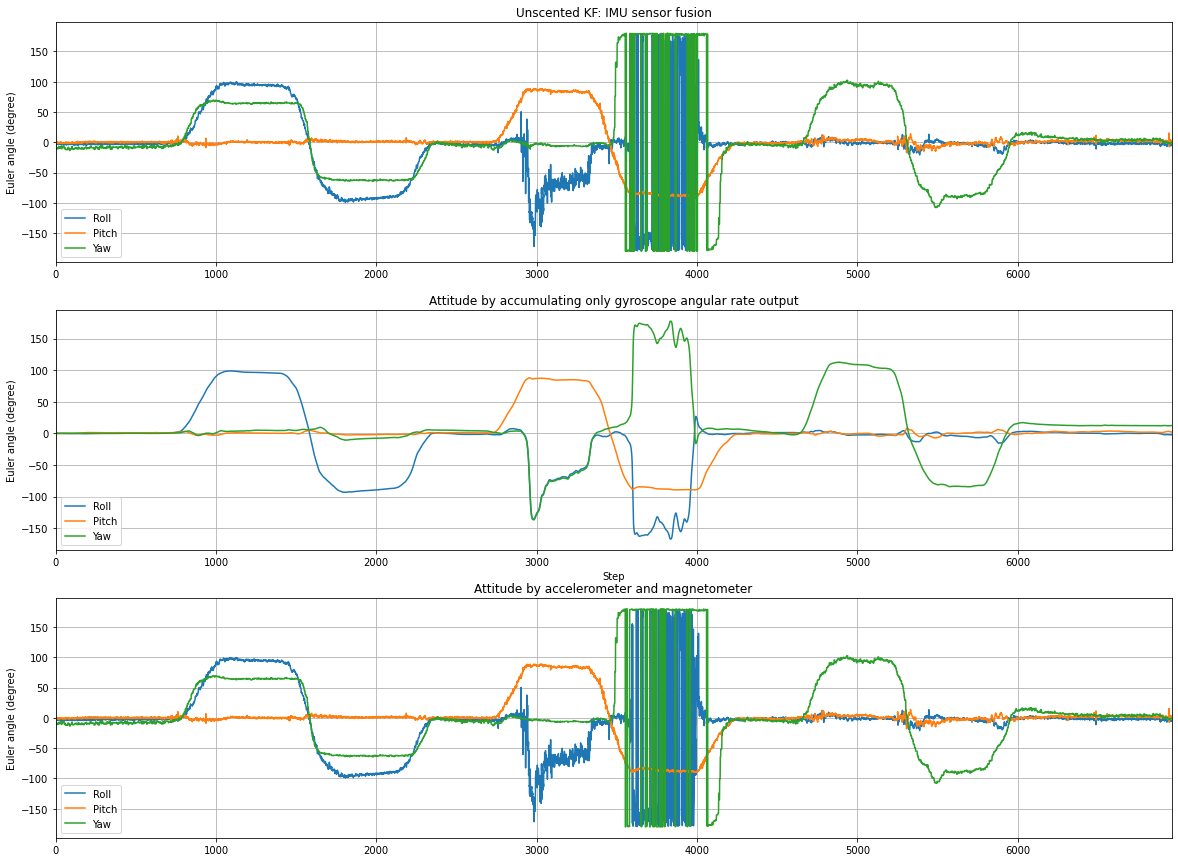

In [5]:
if measurement_update == True:
    title='Unscented KF: IMU sensor fusion'
else:
    title='Unscented KF: Prediction only'

plt.figure(figsize=(20,15))
plt.subplot(3,1,1)    
if f_number == 3:
    # Result plotting    
    plt.plot(np.rad2deg(mu_hist[:,0:2]))
    plt.legend(['Roll','Pitch','Yaw'], loc = 'lower left')
    plt.grid()    
    plt.ylabel('Euler angle (degree)')
    plt.xlim([0,totalLen])
    plt.title(title)
else:
    # Result plotting    
    plt.plot(np.rad2deg(mu_hist))
    plt.legend(['Roll','Pitch','Yaw'], loc = 'lower left')
    plt.grid()    
    plt.ylabel('Euler angle (degree)')
    plt.xlim([0,totalLen])
    plt.title(title)

# Result plotting
plt.subplot(3,1,2)    
plt.plot(np.rad2deg(angle_hist))
plt.legend(['Roll','Pitch','Yaw'], loc = 'lower left')
plt.grid()
plt.xlabel('Step')
plt.ylabel('Euler angle (degree)')
plt.xlim([0,totalLen])
plt.title('Attitude by accumulating only gyroscope angular rate output')

# Measurement updat를 위한 accelerometer와 magnatometer의 자세
plt.subplot(3,1,3)    
plt.plot(np.rad2deg(z_hist))
#plt.plot(z_hist)
plt.legend(['Roll','Pitch','Yaw'], loc = 'lower left')
plt.grid()
plt.ylabel('Euler angle (degree)')
plt.xlim([0,totalLen])
plt.title('Attitude by accelerometer and magnetometer')

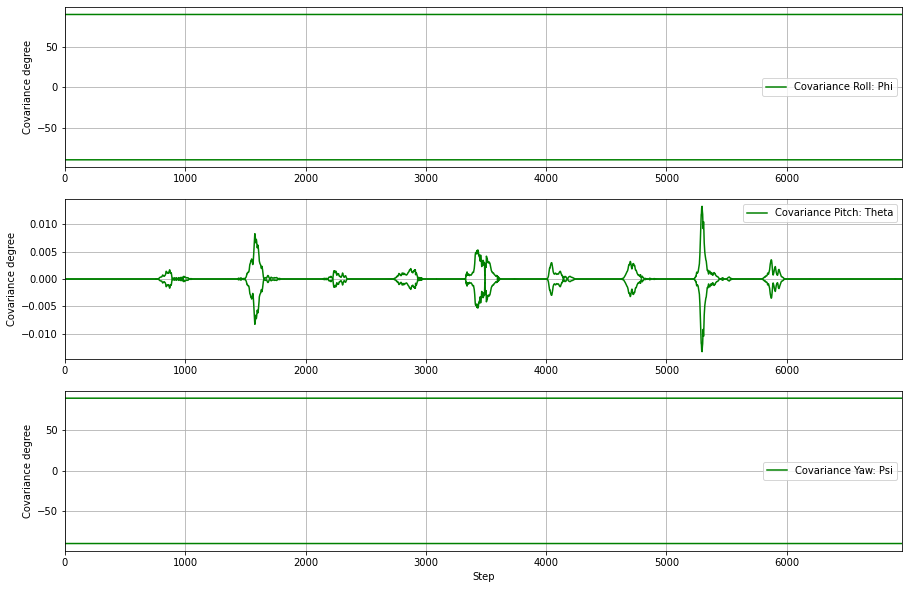

In [6]:
# Covariance plotting
# Result plotting
plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
plt.plot(np.rad2deg(sigma_x_hist[:,0]), 'g')
plt.plot(-np.rad2deg(sigma_x_hist[:,0]), 'g')
plt.grid()
plt.ylabel('Covariance degree')
plt.xlim([0,totalLen])
plt.legend(['Covariance Roll: Phi'])

# Result plotting
plt.subplot(3,1,2)
plt.plot(np.rad2deg(sigma_x_hist[:,1]), 'g')
plt.plot(-np.rad2deg(sigma_x_hist[:,1]), 'g')
plt.grid()
plt.ylabel('Covariance degree')
plt.xlim([0,totalLen])
plt.legend(['Covariance Pitch: Theta'])

# Result plotting
plt.subplot(3,1,3)
plt.plot(np.rad2deg(sigma_x_hist[:,2]), 'g')
plt.plot(-np.rad2deg(sigma_x_hist[:,2]), 'g')
plt.grid()
plt.xlabel('Step')
plt.ylabel('Covariance degree')
plt.xlim([0,totalLen])
plt.legend(['Covariance Yaw: Psi'])

(0.0, 6959.0)

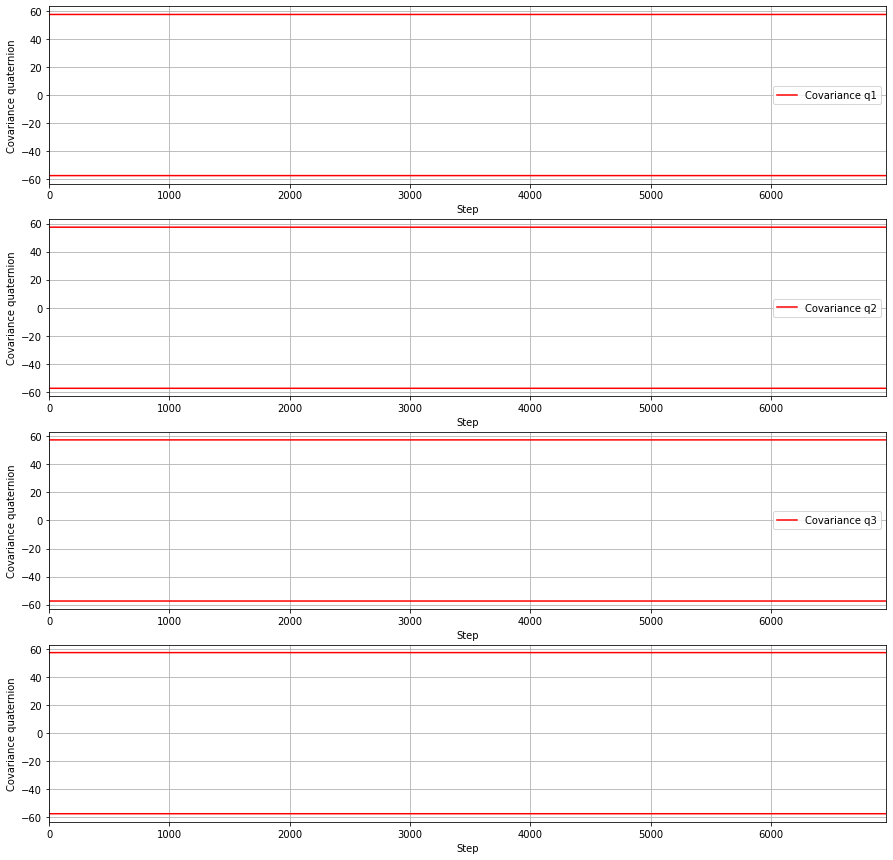

In [7]:
plt.figure(figsize=(15,15))
plt.subplot(4,1,1)
plt.plot(np.rad2deg(np.sqrt(sigma_hist[:,0])), 'r')
plt.plot(-np.rad2deg(np.sqrt(sigma_hist[:,0])), 'r')
plt.grid()
plt.xlabel('Step')
plt.ylabel('Covariance quaternion')
plt.xlim([0,totalLen])
plt.legend(['Covariance q1'])

# Result plotting
plt.subplot(4,1,2)
plt.plot(np.rad2deg(np.sqrt(sigma_hist[:,1])), 'r')
plt.plot(-np.rad2deg(np.sqrt(sigma_hist[:,1])), 'r')
plt.grid()
plt.xlabel('Step')
plt.ylabel('Covariance quaternion')
plt.xlim([0,totalLen])
plt.legend(['Covariance q2'])

# Result plotting
plt.subplot(4,1,3)
plt.plot(np.rad2deg(np.sqrt(sigma_hist[:,2])), 'r')
plt.plot(-np.rad2deg(np.sqrt(sigma_hist[:,2])), 'r')
plt.grid()
plt.xlabel('Step')
plt.ylabel('Covariance quaternion')
plt.xlim([0,totalLen])
plt.legend(['Covariance q3'])

# Result plotting
plt.subplot(4,1,4)
plt.plot(np.rad2deg(np.sqrt(sigma_hist[:,3])), 'r')
plt.plot(-np.rad2deg(np.sqrt(sigma_hist[:,3])), 'r')
plt.grid()
plt.xlabel('Step')
plt.ylabel('Covariance quaternion')
plt.xlim([0,totalLen])

In [8]:
if f_number == 2:
    plt.figure(figsize=(15,15))
    plt.subplot(4,1,1)
    plt.plot(Euler_Truth[:,0])
    plt.plot(np.rad2deg(mu_hist[:,0]))
    plt.grid()
    plt.xlabel('Step')    
    plt.xlim([0,totalLen])
    plt.legend(['True value','Estimated value'])

    plt.subplot(4,1,2)
    plt.plot(Euler_Truth[:,1])
    plt.plot(np.rad2deg(mu_hist[:,1]))
    plt.grid()
    plt.xlabel('Step')    
    plt.xlim([0,totalLen])
    plt.legend(['True value','Estimated value'])

    plt.subplot(4,1,3)    
    plt.plot(Euler_Truth[:,2])
    plt.plot(np.rad2deg(mu_hist[:,2]))
    plt.grid()
    plt.xlabel('Step')    
    plt.xlim([0,totalLen])
    plt.legend(['True value','Estimated value'])